In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import os
import shutil
import torch
import time
from collections import deque
import random
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def build_env(name = 'LunarLander-v3', record_name = None):
    # Delete all contents in lunar-agent folder

    # Initialise the environment
    env = gym.make(name, render_mode="rgb_array")

    if record_name != None and record_name != "":
        if os.path.exists(record_name):
            shutil.rmtree(record_name)

        env = RecordVideo(
            env,
            video_folder=record_name,
            episode_trigger=lambda x: True,  # Record every episode
            name_prefix="training",
            video_length=3000,  # Maximum number of steps to record per episode
        )

    return env

env = build_env()

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

for _ in range(1000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()


# DQN

- ReplayBuffer
- NN
- training formula: Q(s,a) = Q(s,a) + alpha * (R_t+1 + gamma * max Q(s_t+1 ,a) - Q(s_t, a))
https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm
- Q-target:

known problems:
- forgetting: agent forgot best behavior when new experience comes in


### Replay Buffer

In [3]:
class ReplayBuffer():
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque()
    
    def push(self, state, action, reward, next_state, terminated):
        if len(self.buffer) >= self.capacity:
            self.buffer.popleft()
        self.buffer.append((torch.tensor(state), torch.tensor(action), torch.tensor(reward), torch.tensor(next_state), torch.tensor(terminated)))
    
    def sample(self, batch_size):
        '''state, action, reward, next_state, terminated'''
        state, action, reward, next_state, terminated = zip(*random.sample(self.buffer, batch_size))
        return torch.vstack(state), torch.tensor(action), torch.tensor(reward), torch.vstack(next_state), torch.tensor(terminated)
    
    def curren_capacity(self) -> float:
        return len(self.buffer) / self.capacity
    
    def __str__(self):
        state, action, reward, next_state, terminated = self.sample(1)
        return f"state: {state.shape}\naction: {action.shape}\nreward: {reward.shape}\nnext_state: {next_state.shape}\nterminated: {terminated.shape}"



In [4]:
env = build_env()
env.reset()
rb = ReplayBuffer(capacity=50)
action = env.action_space.sample()
state, reward, terminated, truncated, info = env.step(action)
#warmup
for _ in range(100):
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    rb.push(state, action, reward, next_state, terminated)
    state = next_state

state, action, reward, next_state, terminated = rb.sample(10)

print(rb)

env.close()


state: torch.Size([1, 8])
action: torch.Size([1])
reward: torch.Size([1])
next_state: torch.Size([1, 8])
terminated: torch.Size([1])


In [20]:
# History object for stats 

class History:
    def __init__(self):
        self.loss = []
        self.reward = []
        self.epsilon = []
    
    def push(self, loss, reward, epsilon):
        self.loss.append(loss)
        self.reward.append(reward)
        self.epsilon.append(epsilon)
    
    def plot(self):
        fig, axs = plt.subplots(3)
        fig.suptitle('Training Stats')
        axs[0].plot(self.loss)
        axs[0].set_title('Loss')
        axs[1].plot(self.reward)
        axs[1].set_title('Reward')
        axs[2].plot(self.epsilon)
        axs[2].set_title('Epsilon')
        plt.show()
    
    def plot_reward(self):
        plt.plot(self.reward)
        plt.title('Reward')
        plt.show()

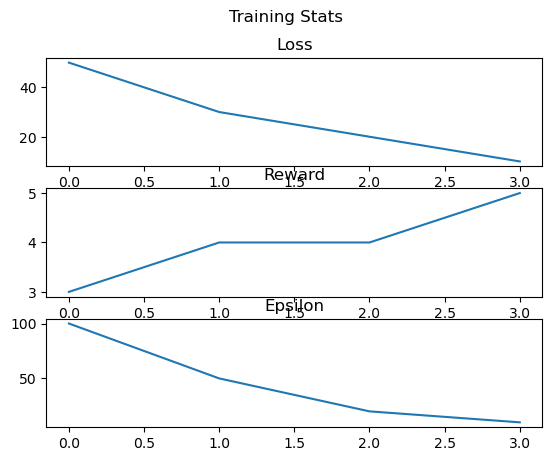

In [6]:
history = History() 
history.push(50, 3, 100)
history.push(30, 4, 50)
history.push(20, 4, 20)
history.push(10, 5, 10)
history.plot()

### Neural network

In [7]:
def build_qnet(state_dim, action_dim):
    state_dim = state_dim
    action_dim = action_dim
    model = torch.nn.Sequential(
        torch.nn.Linear(state_dim, 120),
        torch.nn.ReLU(),
        torch.nn.Linear(120, 84),
        torch.nn.ReLU(),
        torch.nn.Linear(84, action_dim)
    )
    return model


In [8]:
testnet = build_qnet(8, 4)
y = testnet(torch.randn(1, 8))
print(y)

tensor([[-0.2471, -0.1016,  0.1047,  0.1330]], grad_fn=<AddmmBackward0>)


### Greedy policy (DQN is off-policy, use greedy policy for training, but use only model for reference)



<Axes: >

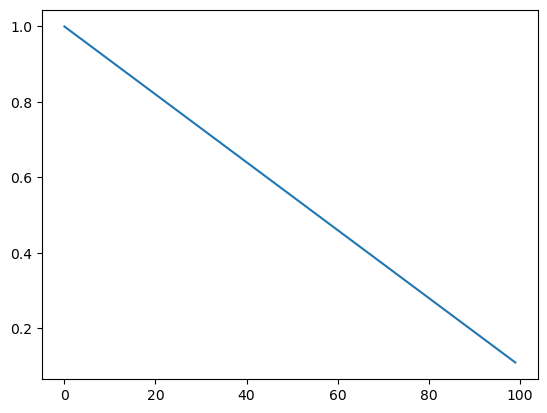

In [9]:
def linear_schedule(start, end, duration, t):
    slope = (end - start) / duration
    return max(slope * t + start, end)

sns.lineplot(x=range(100), y=[linear_schedule(1, 0.1, 100, t) for t in range(100)])


### Optimizer
Adam()

In [ ]:
batch_size = 64
gamma = 0.99
tau = 0.01 #to sync target qnet and training qnet
total_steps = int(5e5)
sync_steps = 100
warm_up = 1000
trainng_freq = 10 # traing every 10 steps
buffer_capacity = int(1e5)
lr = 0.001


### Training

1. given a state, take an action
2. add that action, reward, state to buffer
3. if global step > learning starts (pass warmup) and global step % training freq == 0: 
    - get data from buffer
    - Q_max = target_nn(data.obs).max(1)
    - td_target = data.rewards + gamma * Q_max * (1 - dones)
    - old val = q_net(data.obs)

    loss = mse(td_target, old_val)

    optim.zero_grad
    loss.backward()
    optim.step()

    sync q_net and target q_net 




In [ ]:
env = build_env()
env.reset()
qnet = build_qnet(8, 4)
target_qnet = build_qnet(8, 4)
target_qnet.load_state_dict(qnet.state_dict())
replay_buffer = ReplayBuffer(buffer_capacity)

optimizer = torch.optim.Adam(qnet.parameters(), lr=lr)

#warmup
state = None
for _ in range(warm_up):
    next_state, reward, terminated, truncated, info = env.step(env.action_space.sample())
    if state is not None: 
        replay_buffer.push(state, action, reward, next_state, terminated)
    state = next_state

print(replay_buffer)

loop = tqdm(range(total_steps))
epsilon = 0.0
loss = 0.0
total_rewards = 0
best_rewards = -float('inf')
reward_list = deque()

history = History()
iter_loss = []

for step in loop:
    loop.set_description(f"Step {step}\tepsilon {epsilon:.2f}\tloss {loss:.2f}\ttotal rewards {total_rewards:.2f}\tbest rewards {best_rewards:.2f}\tavg 100 rewards: {sum(reward_list) / len(reward_list):.2f}")

    epsilon = linear_schedule(1, 0.01, total_steps, step)

    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = qnet(torch.tensor(state).float()).argmax().item()

    # pretraining
    next_state, reward, terminated, truncated, info = env.step(action)
    total_rewards += reward

    replay_buffer.push(state, action, reward, next_state, terminated)

    # training
    if step % trainng_freq == 0:
        # greedy epsilon
        
        data = replay_buffer.sample(batch_size)

        rb_state, rb_action, rb_reward, rb_nextstate, rb_done = data

        with torch.no_grad():
            target_max = target_qnet(rb_nextstate).float().max(dim=1).values
            td_target = rb_reward + gamma * target_max * (1 - rb_done.flatten().int())
                
        old_value = qnet(rb_state).gather(1, rb_action.unsqueeze(1)).squeeze()

        loss = torch.nn.functional.mse_loss(old_value, td_target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter_loss.append(loss.item())

        
    # sync every sync_steps
    if step % sync_steps == 0:
        target_qnet.load_state_dict(qnet.state_dict())

    #post training
    state = next_state

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()
        best_rewards = max(best_rewards, total_rewards)
        reward_list.append(total_rewards)
        if len(reward_list) > 100:
            reward_list.popleft()
        total_rewards = 0
        history.push(sum(iter_loss) / len(iter_loss) , total_rewards, epsilon)

env.close()

state: torch.Size([1, 8])
action: torch.Size([1])
reward: torch.Size([1])
next_state: torch.Size([1, 8])
terminated: torch.Size([1])


Step 499999	epsilon 0.01	loss 4.15	total rewards 130.30	best rewards 289.77: 100%|██████████| 500000/500000 [06:26<00:00, 1293.99it/s]   


In [22]:
history.plot_reward()

AttributeError: 'History' object has no attribute 'plot_reward'